In [2]:
from equation.option_pricing import BlackScholes
from optimize.option_princing import BlackScholeOptimizer
from method.nn import MLP, ResNet
from method.hnn import IQO, HybridCQN
from method.qnn import QuantumNeuralNetwork, CorrelatorQuantumNeuralNetwork
from utils.adapters import ResNetFeatures, MLPFeatures

from tqdm import tqdm
import torch.nn.functional as F
import numpy as np
import torch.nn as nn
import torch as tc
import matplotlib.pyplot as plt

2025-10-18 14:56:43.308270: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-18 14:56:43.582744: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-18 14:56:44.565112: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
import math

def m_value(n, k):
    return 3 * math.comb(n, k)

print(m_value(4, 3))  # 9


12


In [ ]:
bse = BlackScholes(eps=1e-10)
data = bse.generate_data(seed=42)
data_teste = bse.generate_data(seed=1924)
epochs = 5000
lr = 1e-2

In [5]:
model = MLP(neurons=5, M=5, activation=nn.Tanh())
opt = BlackScholeOptimizer(data, model, epochs=epochs, lr=lr)
loss = opt.train(return_loss=True)

Trainning: 100%|██████████| 5000/5000 [00:20<00:00, 239.53it/s]


In [6]:
qnn = QuantumNeuralNetwork(n_qubits=9, n_layers=5)
qpinn_opt = BlackScholeOptimizer(data, HybridCQN(classical_pre=None, qnn_block=qnn, classical_post=None), epochs=epochs, lr=lr)
loss_qpinn= qpinn_opt.train(return_loss=True)

Trainning: 100%|██████████| 5000/5000 [4:39:29<00:00,  3.35s/it]  


In [7]:
cqnn = CorrelatorQuantumNeuralNetwork(n_qubits=4, n_layers=5, k=3, n_vertex=9)
cqpinn_opt = BlackScholeOptimizer(data, HybridCQN(classical_pre=None, qnn_block=cqnn, classical_post=None), epochs=epochs, lr=lr)
loss_cqpinn= cqpinn_opt.train(return_loss=True)

Trainning: 100%|██████████| 5000/5000 [21:16<00:00,  3.92it/s]


In [8]:
cqnn_sem = CorrelatorQuantumNeuralNetwork(n_qubits=3, n_layers=5, k=2, n_vertex=9, nonlinear=True)
cqpinn_opt_sem = BlackScholeOptimizer(data, HybridCQN(classical_pre=None, qnn_block=cqnn_sem, classical_post=None), epochs=epochs, lr=lr)
loss_cqpinn_sem= cqpinn_opt_sem.train(return_loss=True)

Trainning: 100%|██████████| 5000/5000 [11:45<00:00,  7.09it/s]


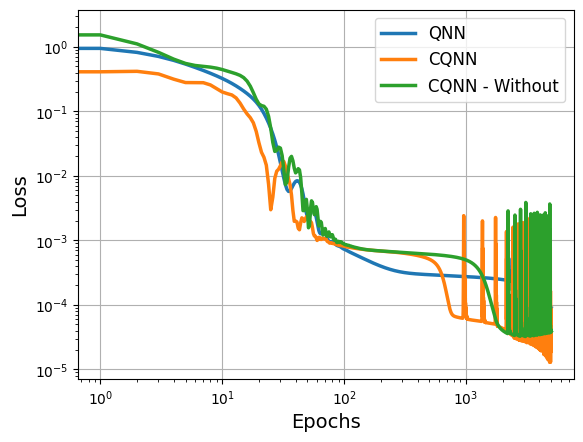

In [15]:
#plt.plot(loss['Total'], lw=2.5,label='Classica')
plt.plot(loss_qpinn['Total'], lw=2.5,label='QNN')
plt.plot(loss_cqpinn['Total'], lw=2.5,label='CQNN')
plt.plot(loss_cqpinn_sem['Total'], lw=2.5,label='CQNN - Without') 
plt.yscale('log')
plt.xscale('log')
plt.legend(fontsize=12)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)

plt.grid(True)
plt.show()

In [10]:
opt.test(data_teste, return_unormalized=True)[1], qpinn_opt.test(data_teste, return_unormalized=True)[1], cqpinn_opt.test(data_teste, return_unormalized=True)[1], cqpinn_opt_sem.test(data_teste, return_unormalized=True)[1]

(0.3707868456840515,
 1.2600716352462769,
 0.1919536590576172,
 0.5277183651924133)

In [11]:
opt.num_params, qpinn_opt.num_params, cqpinn_opt.num_params, cqpinn_opt_sem.num_params

(141, 82, 42, 34)

In [12]:
opt.loss/opt.num_params, qpinn_opt.loss/qpinn_opt.num_params, cqpinn_opt.loss/cqpinn_opt.num_params, cqpinn_opt_sem.loss/cqpinn_opt_sem.num_params

(tensor(1.7347e-07, grad_fn=<DivBackward0>),
 tensor(1.0964e-06, grad_fn=<DivBackward0>),
 tensor(7.1161e-07, grad_fn=<DivBackward0>),
 tensor(1.1336e-06, grad_fn=<DivBackward0>))